In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error # for model evaluation metrics
from sklearn import svm,metrics,datasets


In [43]:
dataDir = ".\spells"
pd.options.display.max_columns=50

df=pd.read_csv(dataDir + '\\lumos\Lumos1.csv' , encoding='utf-8')

data = []
#Read all data from csv file in same directory (same spell)

for folder in os.listdir(dataDir):
    if str(folder) != 'class_testing':
        for filename in os.listdir(dataDir + '\\' + folder):
            f = os.path.join(dataDir + '\\' + folder, filename)
            if os.path.isfile(f):
                #File
                with open(f, 'r') as f:
                    # Use the csv reader to read the file
                    reader = csv.reader(f)
                    next(reader)
                    # Store the data in a list
                    data.append(list(reader))
df

,aX,aY,aZ,rX,rY,rZ
0,1.58,2.06,7.71,0.61,0.31,0.26
1,0.66,2.05,7.91,0.37,0.79,1.96
2,-3.71,-0.35,13.27,0.41,1.41,1.30
3,-5.63,-0.81,17.72,-2.37,1.20,-1.42
4,-2.00,1.13,11.60,-5.37,-1.16,-2.51
5,-0.07,-1.00,4.97,-3.61,1.29,-0.54
6,0.02,-3.53,1.07,-0.43,0.33,-0.21
7,-2.14,-2.28,-1.52,1.80,0.33,0.38
8,-3.45,-1.66,3.03,6.79,0.32,-1.21
9,-2.62,4.38,24.15,4.42,0.47,-0.52


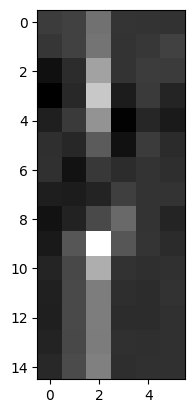

In [63]:

arr = np.array(data[0], dtype=float)
arr_min = arr.min()
arr_max = arr.max()
arr_norm = (arr - arr_min) / (arr_max - arr_min)
plt.imshow(arr_norm,cmap='gray')

In [51]:
#Find longest vector
longest_len = max([len(vector) for vector in data])
print("Longest length: ", longest_len)

Longest length:  51


In [52]:
#Find average length of vectors
avg_len = int(sum([len(vector) for vector in data])/len(data))
print("Average length of sequences: ", avg_len)

Average length of sequences:  18


In [126]:

def normalizeVectors(data): 
    for vectors in data:
        if len(vectors) < avg_len:
            #Apply padding to vectors sequences less than max length     
            difference = avg_len - len(vectors)
            array = np.zeros((difference, 6))
            list_of_arrays = array.tolist()
            vectors.extend(list_of_arrays)
        elif len(vectors) > avg_len:
            #Cut last vectors in sequence to make them average size
            difference = len(vectors) - avg_len
            for i in range(difference): vectors.pop()

normalizeVectors(data)
data

array([[['1.58', '2.06', '7.71', '0.61', '0.31', '0.26'],
        ['0.66', '2.05', '7.91', '0.37', '0.79', '1.96'],
        ['-3.71', '-0.35', '13.27', '0.41', '1.41', '1.3'],
        ...,
        ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
        ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
        ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0']],

       [['0.59', '1.43', '7.96', '-0.43', '0.35', '0.17'],
        ['-1.04', '0.89', '8.66', '0.38', '0.04', '1.18'],
        ['-1.24', '0.78', '9.95', '0.26', '0.15', '0.36'],
        ...,
        ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
        ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
        ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0']],

       [['-0.64', '0.53', '8.48', '-0.5', '0.35', '0.2'],
        ['-0.7', '1.63', '8.52', '0.19', '0.24', '1.01'],
        ['-3.09', '0.68', '10.98', '-0.04', '0.66', '0.67'],
        ...,
        ['-3.7', '1.38', '8.97', '0.77', '-0.63', '-0.76'],
        ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
   

In [255]:
#Additional parameters
batch_size = 10              #length of files
sequence_length = avg_len    #Amount of data vectors in a file
num_features = 6             #Length of data vectors
num_classes = 2

data = np.array(data,dtype=float)

# (x,y,z) x secuencias (archivos) con y vectores de z características
print("Data shape: ", data.shape)

#Etiquetas
#Necesitamos etiquetas de dimension (x,1)
labels = []
for i in range(5): labels.append([0])
for i in range(5): labels.append([1])
labels = np.array(labels)

print("Labels shape: ", labels.shape)

Data shape:  (180, 6)
Labels shape:  (10, 1)


In [256]:
#Aplicamos escalado min max

scaler = MinMaxScaler()
#MinMaxScaler solo toma arrays de 1 o 2 dimensiones por lo que tenemos que transformar los datos
X_reshaped = data.reshape(-1,num_features)
X_scaled=scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(batch_size, sequence_length, num_features)

#Separamos en conjuntos de training y de test
train_data, test_data = train_test_split(X_scaled, test_size=0.3, shuffle=False)
#Ahora tenemos que crear los dos conjuntos de labels
labels_train = labels[0:7] 
labels_test = labels[7:10]

#Estructura de la red neuronal
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(sequence_length, 6)))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam')


model.fit(train_data, labels_train, epochs=10, batch_size=batch_size, validation_data=(test_data, labels_test))

Epoch 1/10
1/1 [==============================] - 1s 528ms/step - loss: 0.6308 - val_loss: 0.9161
Epoch 2/10
1/1 [==============================] - 0s 28ms/step - loss: 0.6303 - val_loss: 0.9186
Epoch 3/10
1/1 [==============================] - 0s 28ms/step - loss: 0.6298 - val_loss: 0.9210
Epoch 4/10
1/1 [==============================] - 0s 29ms/step - loss: 0.6294 - val_loss: 0.9234
Epoch 5/10
1/1 [==============================] - 0s 29ms/step - loss: 0.6289 - val_loss: 0.9258
Epoch 6/10
1/1 [==============================] - 0s 28ms/step - loss: 0.6285 - val_loss: 0.9282
Epoch 7/10
1/1 [==============================] - 0s 28ms/step - loss: 0.6280 - val_loss: 0.9306
Epoch 8/10
1/1 [==============================] - 0s 28ms/step - loss: 0.6276 - val_loss: 0.9331
Epoch 9/10
1/1 [==============================] - 0s 28ms/step - loss: 0.6272 - val_loss: 0.9355
Epoch 10/10
1/1 [==============================] - 0s 28ms/step - loss: 0.6267 - val_loss: 0.9379


In [257]:
##### Step 7 - Use model to make predictions
# Predict the result on training data
pred_train = model.predict(train_data)
# Predict the result on test data
pred_test = model.predict(test_data)


##### Step 8 - Model Performance Summary
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Note, the last parameter in each layer is bias while the rest are weights")
print("")
for layer in model.layers:
    print(layer.name)
    for item in layer.get_weights():
        print("  ", item)



1/1 [==============================] - 0s 20ms/step

-------------------- Model Summary --------------------
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 18, 1)             7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Note, the last parameter in each layer is bias while the rest are weights

dense_20
   [[-0.72160614]
 [ 0.5370714 ]
 [ 0.04343458]
 [ 0.16806464]
 [-0.66382843]
 [-0.09615263]]
   [-0.00997212]


In [279]:
#Probamos ejemplo de prueba
example_data = []

with open(dataDir + '\\testing\\test1.csv', 'r') as f:
    # Use the csv reader to read the file
    reader = csv.reader(f)
    next(reader)
    # Store the data in a list
    example_data.append(list(reader))

normalizeVectors(example_data)

example_data = np.array(example_data,dtype=float)

print(example_data)
prediction = model.predict(example_data)
prediction = np.where(prediction > 0.5, 1, 0)
print(prediction)

votes_0 = 0
votes_1 = 0

for vector in prediction[0]:
    if vector[0] == 0: votes_0 +=1
    else: votes_1 +=1
print(votes_0, votes_1)

[[[ 2.020e+00  1.470e+00  9.600e+00  1.800e-01  0.000e+00  3.100e-01]
  [ 2.040e+00  1.530e+00  8.620e+00  1.000e-02  5.000e-02  4.300e-01]
  [ 7.600e-01  1.160e+00  1.012e+01  4.000e-01  2.500e-01  5.500e-01]
  [ 4.000e-02  1.070e+00  1.292e+01  8.000e-02  8.500e-01  8.300e-01]
  [-2.550e+00  4.800e-01  1.675e+01 -3.010e+00  6.700e-01 -1.280e+00]
  [ 3.000e-02  6.300e-01  8.040e+00 -4.460e+00  1.000e-01 -1.240e+00]
  [ 2.630e+00 -2.640e+00  1.280e+00 -2.400e+00  2.400e-01 -9.000e-02]
  [-4.300e-01 -5.470e+00 -5.000e-02 -3.200e-01  5.000e-01  2.400e-01]
  [-2.550e+00 -5.070e+00  1.310e+00  2.250e+00  8.800e-01 -7.300e-01]
  [-2.710e+00 -6.600e-01  4.640e+00  5.660e+00  1.750e+00 -2.000e+00]
  [ 4.350e+00  6.340e+00  1.957e+01  3.320e+00  4.600e-01 -2.280e+00]
  [ 2.260e+00  7.200e-01  1.020e+01 -5.700e-01 -7.000e-02  4.500e-01]
  [-2.500e-01  9.000e-02  1.025e+01 -3.400e-01  4.000e-02  4.200e-01]
  [ 4.100e-01  6.900e-01  8.750e+00 -9.000e-02  2.000e-02  2.000e-02]
  [ 4.600e-01  5.900